In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve, auc, confusion_matrix



In [6]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
86847,00021423_000.png,Infiltration,0,21423,46,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_010/images/00021423_000.png,1.0
72398,00017835_032.png,Effusion|Pneumonia,32,17835,49,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_008/images/00017835_032.png,1.0
88251,00021835_019.png,No Finding,19,21835,39,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00021835_019.png,0.0


In [7]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

In [8]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs, 256),  
                        nn.ReLU(), 
                        nn.Dropout(0.2),
                        nn.Linear(256, 1),                   
                        nn.Sigmoid())

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [9]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [11]:
# model file, disease pairs, plot color
to_test = []
to_test.append(("Hernia", "/kaggle/input/densenet-held-out/densenet_no_hernia.model", "red"))
to_test.append(("Consolidation", "/kaggle/input/densenet-held-out/densenet_no_consolidation.model", "blue"))
to_test.append(("Infiltration", "/kaggle/input/densenet-held-out/densenet_no_infiltration.model", "green"))


In [15]:
def test(held_out_disease, model_file, color):
    model.load_state_dict(torch.load(model_file))
    model.eval()
    print(f"Running testing for {held_out_disease} with model {model_file}")
    
    held_out_df = all_xray_df[all_xray_df['Finding Labels'] == held_out_disease]
    if held_out_df.shape[0] < 2500:
        held_out_df = held_out_df.sample(held_out_df.shape[0], random_state=25)
    else:
        held_out_df = held_out_df.sample(2500, random_state=25)
    print(f"Num samples with only {held_out_disease}:", held_out_df.shape[0])
    
    no_findings_df = all_xray_df[all_xray_df['Finding Labels'] == "No Finding"]
    no_findings_df = no_findings_df.sample(5000 - held_out_df.shape[0], random_state=25)
    print(f"Num samples with No Finding:", no_findings_df.shape[0])
    #no_findings_df = no_findings_df.sample(n=held_out_df.shape[0]) # this might include samples the given model was trainged on, but whatever
    print(f"Keeping {no_findings_df.shape[0]} random 'No Findings' samples for testing")
    
    test_df = held_out_df.append(no_findings_df)
    print(f"Combined test df is {test_df.shape[0]} samples")
    
    images = list(test_df['path'])
    labels = list(test_df['Binary Labels'].map(lambda x: [x]))

    test = my_set(images, labels, transform = my_transform)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers = 2)
    
    test_correct = 0
    test_total = 0
    pred_label = []
    pred_for_roc_curve = []
    for data, target in tqdm(test_loader):
        target = target.squeeze(1)
        data, target = data.to(device), target.to(device)
        out = model(data)
        predicted = (out>0.5).float()
        pred_label.extend(predicted.tolist())
        pred_for_roc_curve.extend(out.tolist())
        test_correct += (predicted == target).sum().item()
        test_total += target.size(0)
        del data
        gc.collect()
        torch.cuda.empty_cache()
    print('Testing Accuracy: {}'.format((100 * test_correct / test_total)))
    acu = (100 * test_correct / test_total)
    
    model_confusion_matrix = confusion_matrix(labels, pred_label)
    print("Confusion matrix\n", model_confusion_matrix)
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(labels, pred_for_roc_curve)
    c_ax.plot(fpr, tpr, color=color, label='%s AUC:%0.2f'  % (held_out_disease, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig(f"{held_out_disease}.png")
    print("Test done")
    print()

Running testing for Hernia with model /kaggle/input/densenet-held-out/densenet_no_hernia.model
Num samples with only Hernia: 110
Num samples with No Finding: 4890
Keeping 4890 random 'No Findings' samples for testing
Combined test df is 5000 samples


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


Testing Accuracy: 71.02
Confusion matrix
 [[3510 1380]
 [  69   41]]
Test done



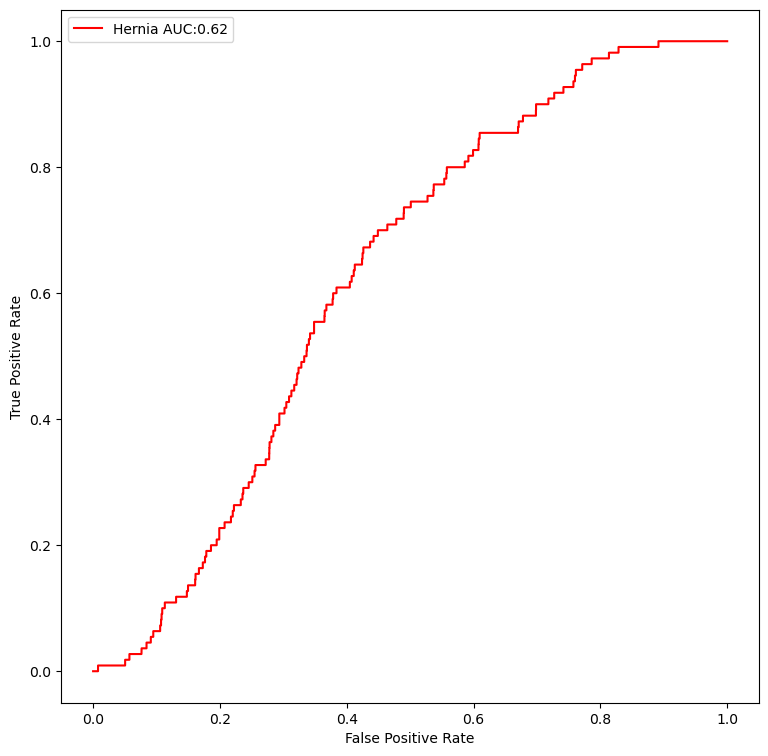

In [16]:
test(*to_test[0])

In [ ]:
test(*to_test[1])

Running testing for Infiltration with model /kaggle/input/densenet-held-out/densenet_no_infiltration.model
Num samples with only Infiltration: 2500
Num samples with No Finding: 2500
Keeping 2500 random 'No Findings' samples for testing
Combined test df is 5000 samples


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


Testing Accuracy: 52.34
Confusion matrix
 [[2131  369]
 [2014  486]]
Test done



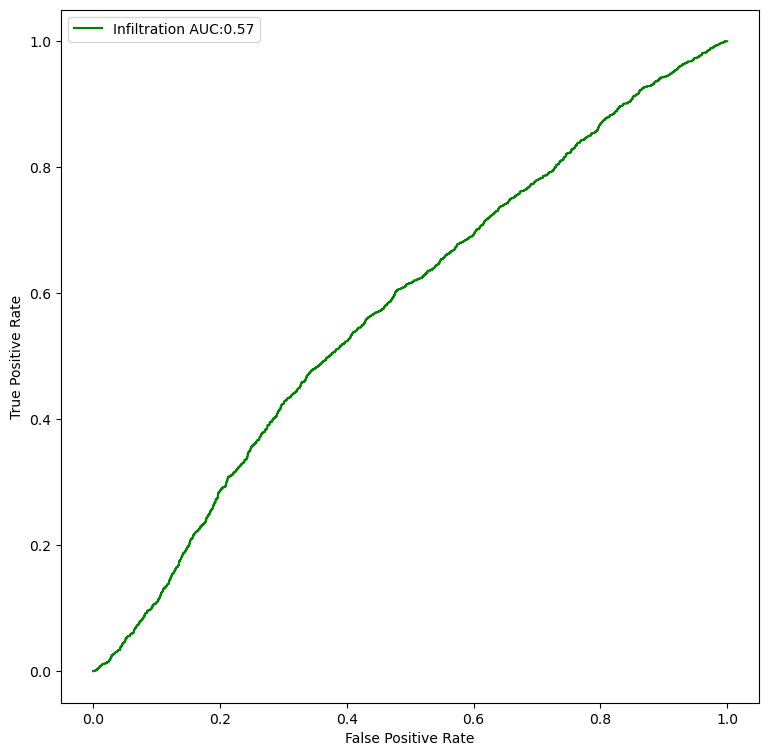

In [17]:
test(*to_test[2])